### 1. Why Layer Normalization?
- **Purpose**: Stabilizes the training of deep neural networks by regularizing neuron dynamics within one layer (across features) via mean and variance statistics.
- **Application**: Normalizes activations **per sample/token**, not across the batch.
- **Use Case**: Works well for sequential data like transformers.

### 2. Math: Layer Normalization
Given input **X** ($n \times d$), where:
- $n$ = context length (number of tokens)
- $d$ = embedding dimension
1. **Mean** per token:
 $$
\mu_i = \frac{1}{d} \sum_{j=1}^{d} X_{ij} \quad (\mu \in \mathbb{R}^{n \times 1})
$$
2. **Variance** per token:
 $$
\sigma^2_i = \frac{1}{d} \sum_{j=1}^{d} (X_{ij} - \mu_i)^2 \quad (\sigma^2 \in \mathbb{R}^{n \times 1})
$$
3. **Normalize**:
 $$
\hat{X}_{ij} = \frac{X_{ij} - \mu_i}{\sqrt{\sigma_i^2 + \epsilon}} \quad (\hat{X} \in \mathbb{R}^{n \times d})
$$
4. **Scale and Shift**:
 $$
Y_{ij} = \gamma_j \hat{X}_{ij} + \beta_j \quad (Y \in \mathbb{R}^{n \times d})
$$
- $\gamma, \beta \in \mathbb{R}^{d \times 1}$
---

### 3. Can We Avoid Calculating the Mean? Why RMS Normalization?
- **RMS Normalization**: Avoids the mean computation, uses RMS (because variance calculation needs mean) to simplify computations. Mean normalization has little impact on the success of LayerNorm.
- **Use Case**: 7% to 64% reduced running term against LayerNorm.

### 4. Math: RMS Normalization
Given input **X** ($n \times d$):
1. **RMS** per token:
 $$
\text{RMS}_i = \sqrt{\frac{1}{d} \sum_{j=1}^{d} (X_{ij})^2} \quad (\text{RMS} \in \mathbb{R}^{n \times 1})
$$
2. **Normalize**:
 $$
\hat{X}_{ij} = \frac{X_{ij}}{\text{RMS}_i} \quad (\hat{X} \in \mathbb{R}^{n \times d})
$$
3. **Scale**:
 $$
Y_{ij} = \gamma_j \hat{X}_{ij} \quad (Y \in \mathbb{R}^{n \times d})
$$
- $\gamma \in \mathbb{R}^{d \times 1}$
Reference: Zhang, B., & Sennrich, R. (2019). Root mean square layer normalization. Advances in Neural Information Processing Systems, 32.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('dark_background')
np.random.seed(47)
torch.manual_seed(47)

batch_size, context_length, embedding_size = 2, 4, 8
batch_input = torch.randn(batch_size, context_length, embedding_size)

In [2]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.shift_parameters = nn.Parameter(
            torch.zeros(features), requires_grad=True
        )
        self.scale_parameters = nn.Parameter(
            torch.ones(features), requires_grad=True
        )
        self.eps = eps

    def forward(self, input_):
        mean_vector = input_.mean(axis=-1, keepdim=True)
        var_vector = input_.var(axis=-1, keepdim=True)

        mean_shifted_scaled_input = (
            (input_ - mean_vector) /
            torch.sqrt(var_vector + self.eps)
        )
        
        parameterized_mean_shifted_scaled_input = (
            mean_shifted_scaled_input * 
            self.scale_parameters + 
            self.shift_parameters
        )
        return parameterized_mean_shifted_scaled_input

In [3]:
class RMSNorm(nn.Module):
    def __init__(self, features, eps=1e-5):
        super().__init__()
        self.scale_parameters = nn.Parameter(
            torch.ones(features), 
            requires_grad=True
        )
        self.eps = eps

    def forward(self, input_):
        rms_vector = (
            (input_ ** 2).mean(axis=-1, keepdim=True) + self.eps
        ).sqrt()
        
        normalized_input = input_ / rms_vector
        scaled_input = (
            normalized_input * self.scale_parameters
        )

        return scaled_input

In [4]:
layer_norm = LayerNorm(features=embedding_size)
rms_norm = RMSNorm(features=embedding_size)

batch_input_post_layer_norm = layer_norm(batch_input)
batch_input_post_rms_norm = rms_norm(batch_input)

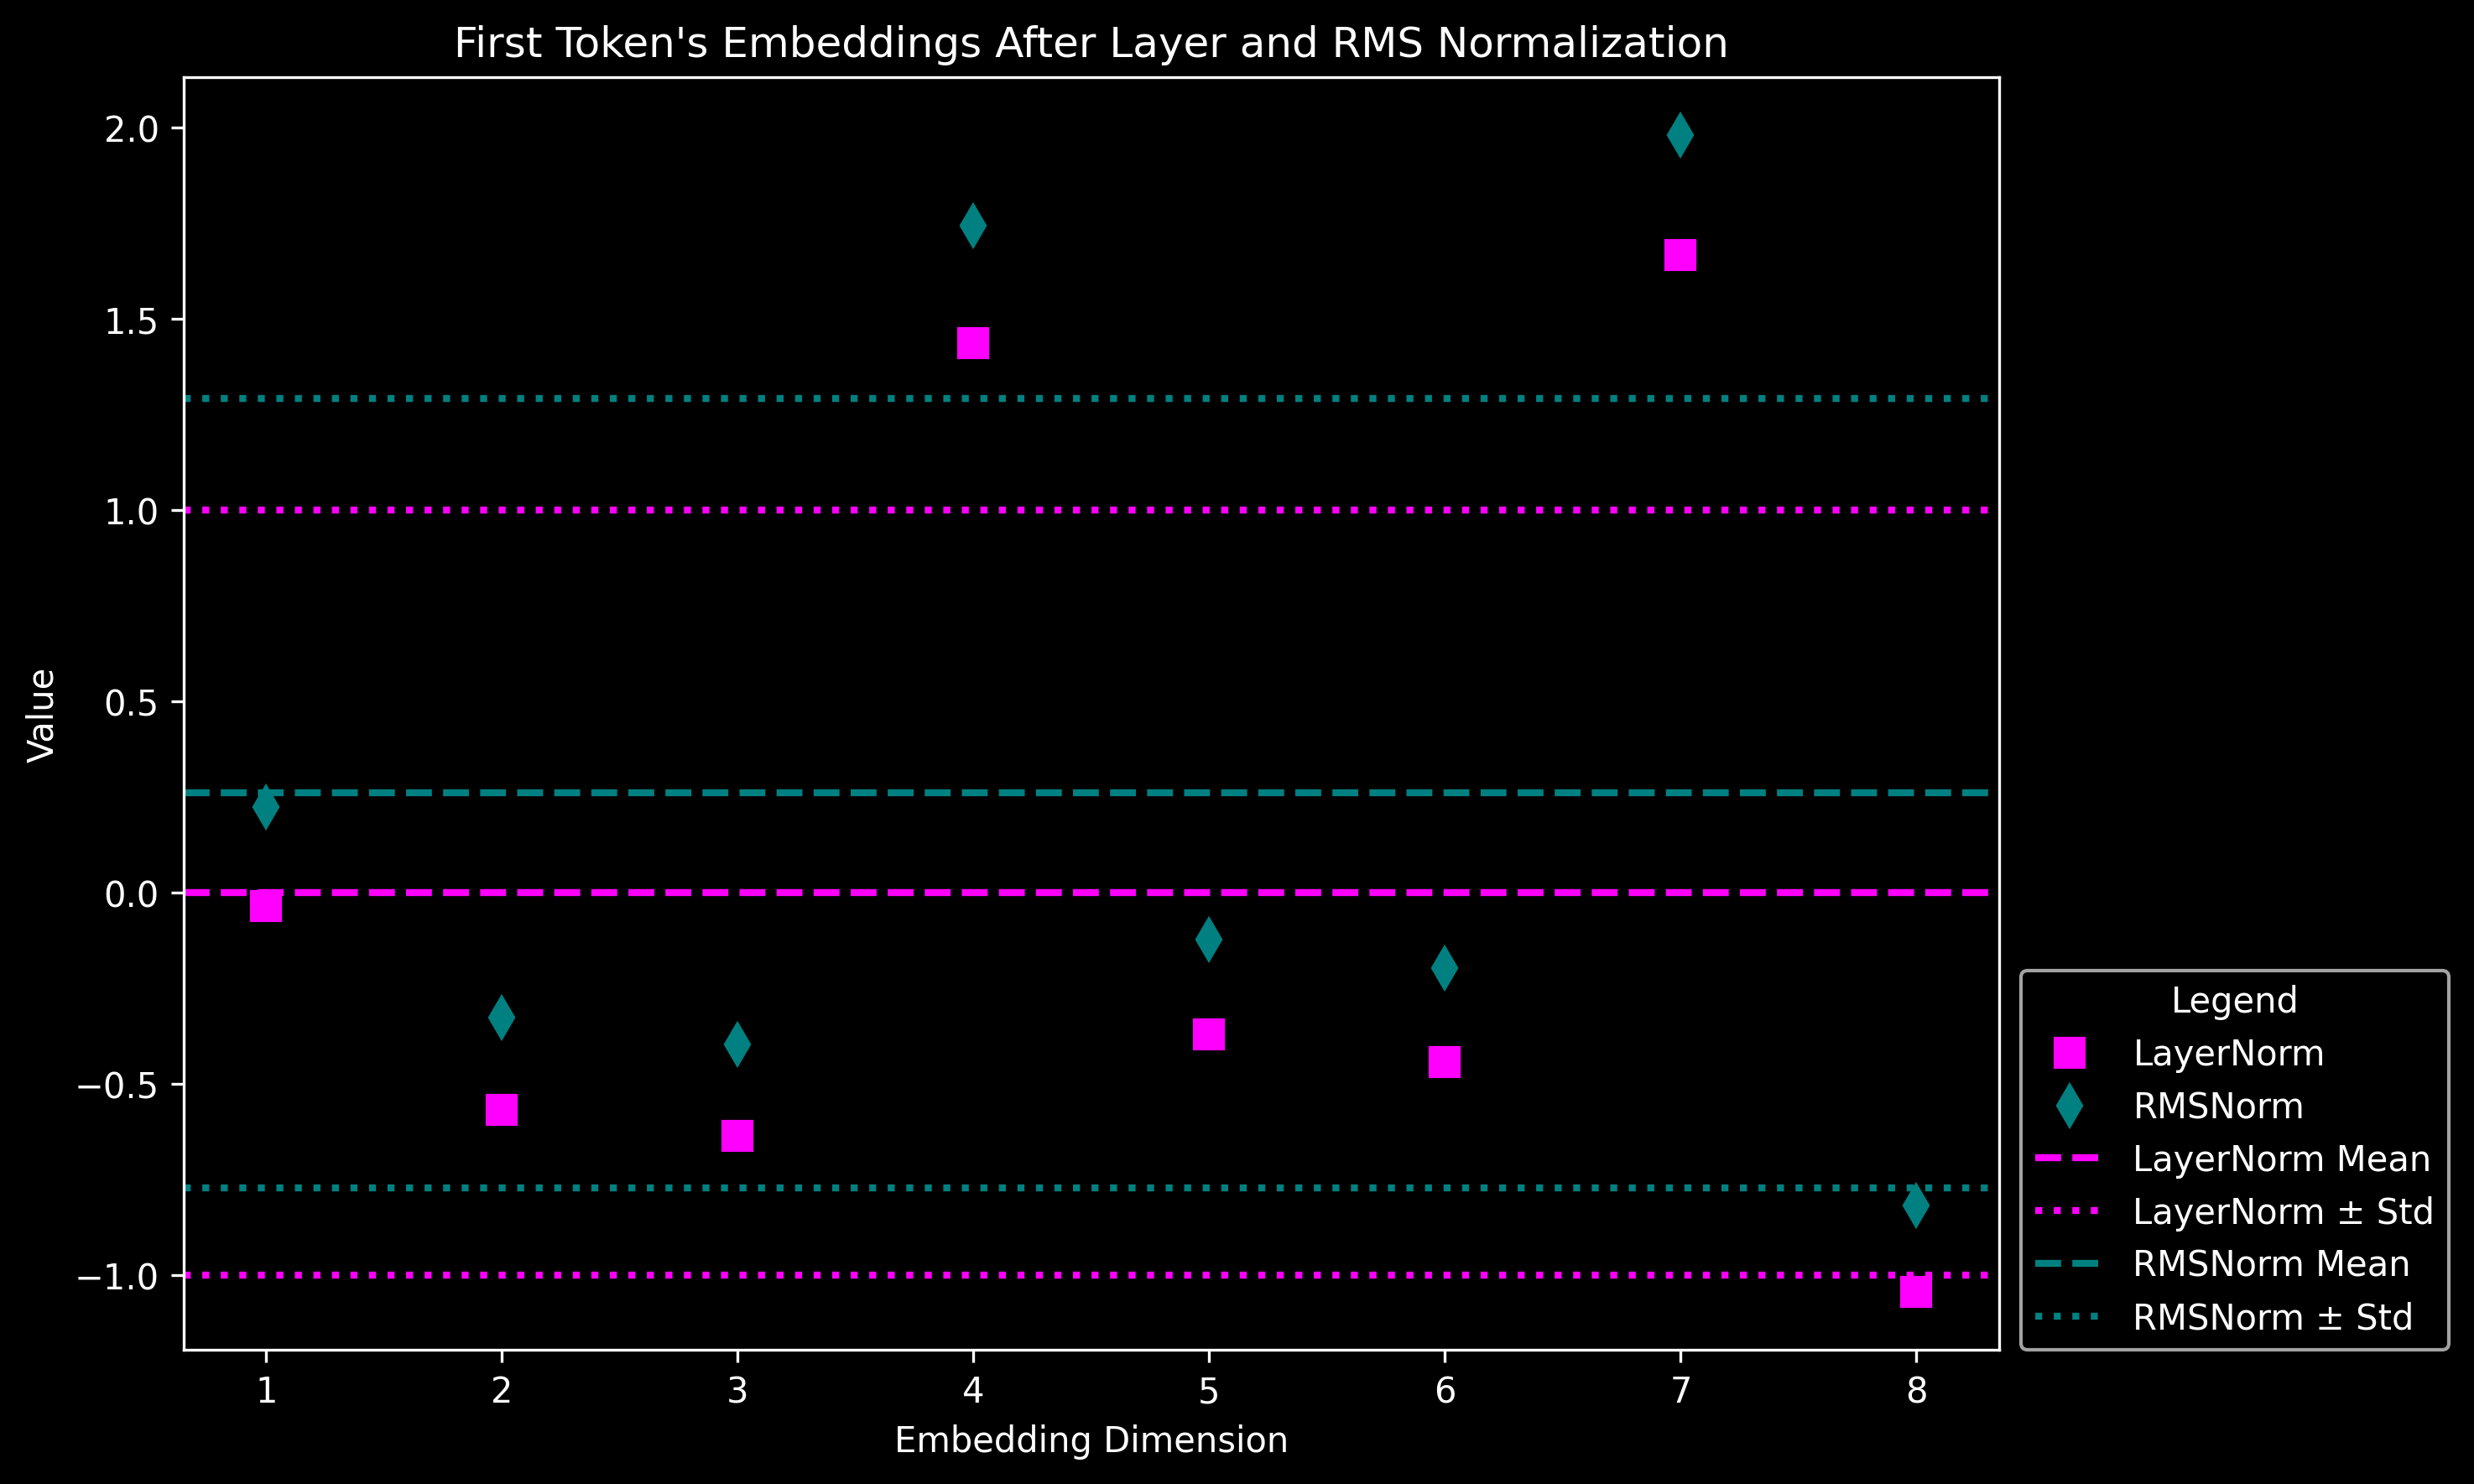

In [5]:
first_token_layer_norm = batch_input_post_layer_norm[0, 0].detach().numpy()
first_token_rms_norm = batch_input_post_rms_norm[0, 0].detach().numpy()

layer_norm_mean = np.mean(first_token_layer_norm)
layer_norm_std = batch_input_post_layer_norm[0][0].std().detach().numpy()
rms_norm_mean = np.mean(first_token_rms_norm)
rms_norm_std = batch_input_post_rms_norm[0][0].std().detach().numpy()

x = np.arange(1, len(first_token_layer_norm) + 1)

plt.figure(figsize=(10, 6), dpi=300)

plt.plot(x, first_token_layer_norm, 's', label="LayerNorm", markersize=8, color='magenta')
plt.plot(x, first_token_rms_norm, 'd', label="RMSNorm", markersize=8, color='teal')

# Add horizontal lines for mean and standard deviation
plt.axhline(layer_norm_mean, color='magenta', linestyle='--', linewidth=2, alpha=1.0, label="LayerNorm Mean")
plt.axhline(layer_norm_mean + layer_norm_std, color='magenta', linestyle=':', linewidth=2, alpha=1.0, label="LayerNorm ± Std")
plt.axhline(layer_norm_mean - layer_norm_std, color='magenta', linestyle=':', linewidth=2, alpha=1.0)

plt.axhline(rms_norm_mean, color='teal', linestyle='--', linewidth=2, alpha=1.0, label="RMSNorm Mean")
plt.axhline(rms_norm_mean + rms_norm_std, color='teal', linestyle=':', linewidth=2, alpha=1.0, label="RMSNorm ± Std")
plt.axhline(rms_norm_mean - rms_norm_std, color='teal', linestyle=':', linewidth=2, alpha=1.0)

# Add labels and legend
plt.title("First Token's Embeddings After Layer and RMS Normalization", fontsize=12)
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.xticks(x)
plt.legend(loc='lower center', bbox_to_anchor=(1.13, 0), title="Legend", borderaxespad=0.)
plt.tight_layout()
plt.show()

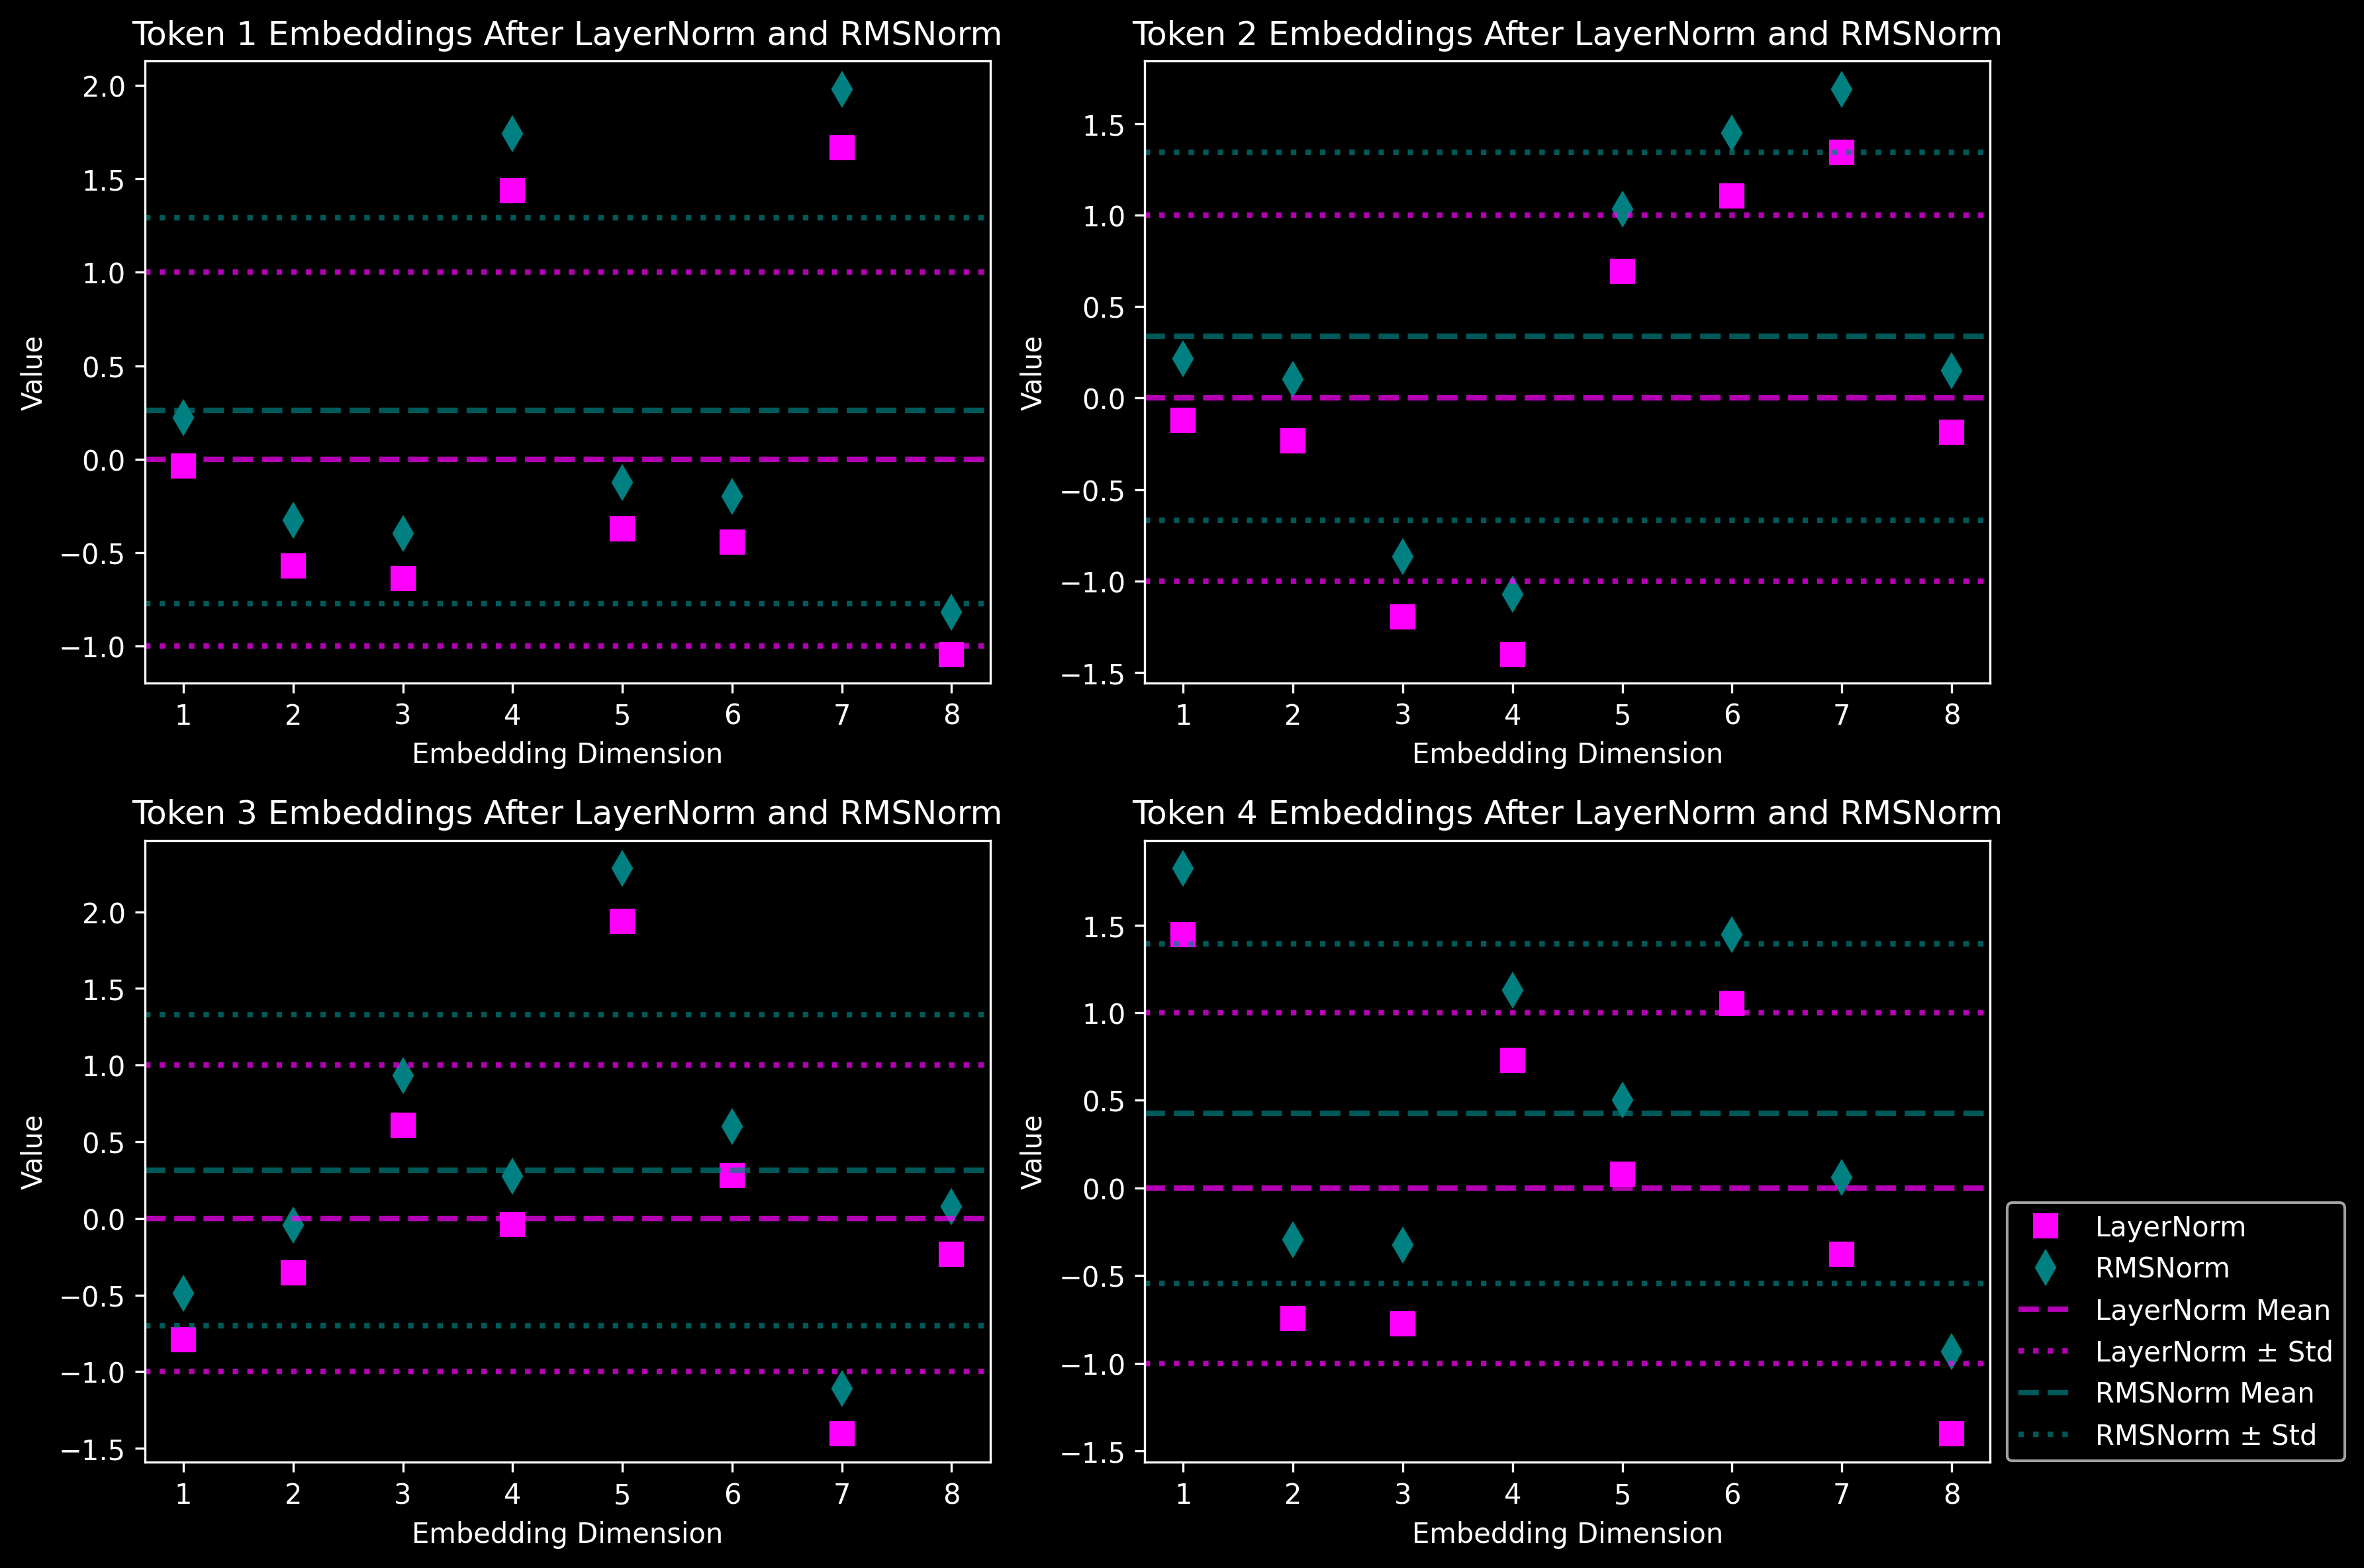

In [6]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=300)

# Loop through each token (i.e., token 0, token 1, token 2, etc.)
for token_index in range(context_length):
    # Extract the token embeddings after LayerNorm and RMSNorm for each token
    token_layer_norm = batch_input_post_layer_norm[0, token_index].detach().numpy()
    token_rms_norm = batch_input_post_rms_norm[0, token_index].detach().numpy()

    # Calculate the mean and standard deviation for each token's embeddings
    layer_norm_mean = np.mean(token_layer_norm)
    layer_norm_std = batch_input_post_layer_norm[0, token_index].std().detach().numpy()
    rms_norm_mean = np.mean(token_rms_norm)
    rms_norm_std = batch_input_post_rms_norm[0, token_index].std().detach().numpy()

    # Create the x-axis values (embedding dimension)
    x = np.arange(1, len(token_layer_norm) + 1)

    # Select the appropriate subplot (2x2 grid)
    ax = axes[token_index // 2, token_index % 2]

    # Define distinct colors for LayerNorm and RMSNorm
    layer_norm_color = 'magenta'
    rms_norm_color = 'teal'

    # Plot the embeddings for LayerNorm and RMSNorm for each token
    ax.plot(x, token_layer_norm, 's', label="LayerNorm", markersize=8, color=layer_norm_color)
    ax.plot(x, token_rms_norm, 'd', label="RMSNorm", markersize=8, color=rms_norm_color)

    # Add horizontal lines for mean and standard deviation
    ax.axhline(layer_norm_mean, color=layer_norm_color, linestyle='--', linewidth=2, alpha=0.7, label="LayerNorm Mean")
    ax.axhline(layer_norm_mean + layer_norm_std, color=layer_norm_color, linestyle=':', linewidth=2, alpha=0.7, label="LayerNorm ± Std")
    ax.axhline(layer_norm_mean - layer_norm_std, color=layer_norm_color, linestyle=':', linewidth=2, alpha=0.7)

    ax.axhline(rms_norm_mean, color=rms_norm_color, linestyle='--', linewidth=2, alpha=0.7, label="RMSNorm Mean")
    ax.axhline(rms_norm_mean + rms_norm_std, color=rms_norm_color, linestyle=':', linewidth=2, alpha=0.7, label="RMSNorm ± Std")
    ax.axhline(rms_norm_mean - rms_norm_std, color=rms_norm_color, linestyle=':', linewidth=2, alpha=0.7)

    # Set labels for the axes
    ax.set_title(f"Token {token_index+1} Embeddings After LayerNorm and RMSNorm", fontsize=12)
    ax.set_xlabel("Embedding Dimension")
    ax.set_ylabel("Value")

    if token_index == context_length - 1:
        ax.legend(loc='lower center', bbox_to_anchor=(1.22, -0.0197), fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('layer_rms_normalization.png', dpi=300)
plt.show()